<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/FXPROBOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the required libraries

In [ ]:
!pip install yfinance --user

In [2]:
import requests
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import warnings
from termcolor import colored as cl
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (24, 12)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Extraction

In [63]:
#read data
df = pd.read_csv('/content/drive/MyDrive/data/eurusd30.csv', parse_dates=True)
# #setting index as date because some statsmodels might not work
df.index = pd.to_datetime(df['Time'])
print(len(df))
df.head()

122736


,Time,Open,High,Low,Close,Volume
Time,,,,,,
2010-01-01 00:00:00,2010-01-01 00:00:00,1.432840,1.432940,1.432265,1.432840,5.721000e+08
2010-01-01 00:30:00,2010-01-01 00:30:00,1.432825,1.432985,1.432340,1.432785,5.253000e+08
2010-01-01 01:00:00,2010-01-01 01:00:00,1.432885,1.432955,1.432090,1.432870,5.663000e+08
2010-01-01 01:30:00,2010-01-01 01:30:00,1.432735,1.433035,1.432135,1.432655,4.402000e+08
2010-01-01 02:00:00,2010-01-01 02:00:00,1.432900,1.433030,1.432295,1.432860,5.386000e+08


# Add RSI, MACD, CCI indicators to df

In [64]:
# constants
data_window = 1000
macd_slow = 26
macd_fast = 12
macd_smooth = 9
cci_ct = 0.015 #CCI = (AveP - SMA_of_AveP) / (0.015 * Mean Deviation)
cci_period = 20
rsi_period = 14

def get_macd(df, slow, fast, smooth):
    exp1 = df['Close'].ewm(span = fast, adjust = False).mean()
    exp2 = df['Close'].ewm(span = slow, adjust = False).mean()
    exp1_8 = df['Close'].ewm(span = fast*8, adjust = False).mean()
    exp2_8 = df['Close'].ewm(span = slow*8, adjust = False).mean()
    # 30Mn MACD
    df['macd'] = pd.DataFrame(exp1 - exp2)
    df['signal']  = pd.DataFrame(df['macd'].ewm(span = smooth, adjust = False).mean())
    df['hist'] = pd.DataFrame(df['macd'] - df['signal'])
    # 4Hour MACD
    df['macd8'] = pd.DataFrame(exp1_8 - exp2_8)
    df['signal8']  = pd.DataFrame(df['macd8'].ewm(span = smooth, adjust = False).mean())
    df['hist8'] = pd.DataFrame(df['macd8'] - df['signal8'])
    return df

def get_cci(df, n, constant): 
    TP = (df['High'] + df['Low'] + df['Close']) / 3 
    #moving_avg = ts_log.rolling(12).mean()
    CCI = (pd.Series((TP - TP.rolling(n).mean()) / (constant * TP.rolling(n).std()), name = 'CCI_' + str(n))).dropna()   
    return CCI

def get_rsi(df, lookback):
    ret = df['Close'].diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(df['Close'].index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df = get_macd(df, macd_slow, macd_fast, macd_smooth)
df['cci'] = get_cci(df, cci_period, cci_ct)
df['rsi'] = get_rsi(df, rsi_period)
df = df[df.index.dayofweek < 5]

sample_df = df.tail(data_window)
sample_df.head()

,Time,Open,High,Low,Close,Volume,macd,signal,hist,macd8,signal8,hist8,cci,rsi
Time,,,,,,,,,,,,,,
2016-12-02 04:00:00,2016-12-02 04:00:00,1.068115,1.068950,1.068040,1.068275,2.124380e+09,0.001284,0.001234,0.000050,0.001085,0.000918,0.000167,129.088061,74.881186
2016-12-02 04:30:00,2016-12-02 04:30:00,1.068330,1.068475,1.067985,1.068040,1.578260e+09,0.001281,0.001243,0.000037,0.001129,0.000960,0.000169,111.864536,71.821631
2016-12-02 05:00:00,2016-12-02 05:00:00,1.068255,1.068690,1.067970,1.068580,1.526890e+09,0.001306,0.001256,0.000051,0.001177,0.001003,0.000174,112.396295,74.409135
2016-12-02 05:30:00,2016-12-02 05:30:00,1.068335,1.068650,1.067985,1.068270,1.252795e+09,0.001287,0.001262,0.000025,0.001220,0.001047,0.000174,96.020501,70.411864
2016-12-02 06:00:00,2016-12-02 06:00:00,1.068370,1.068765,1.068160,1.068360,1.507540e+09,0.001264,0.001262,0.000002,0.001263,0.001090,0.000173,98.678174,70.900614


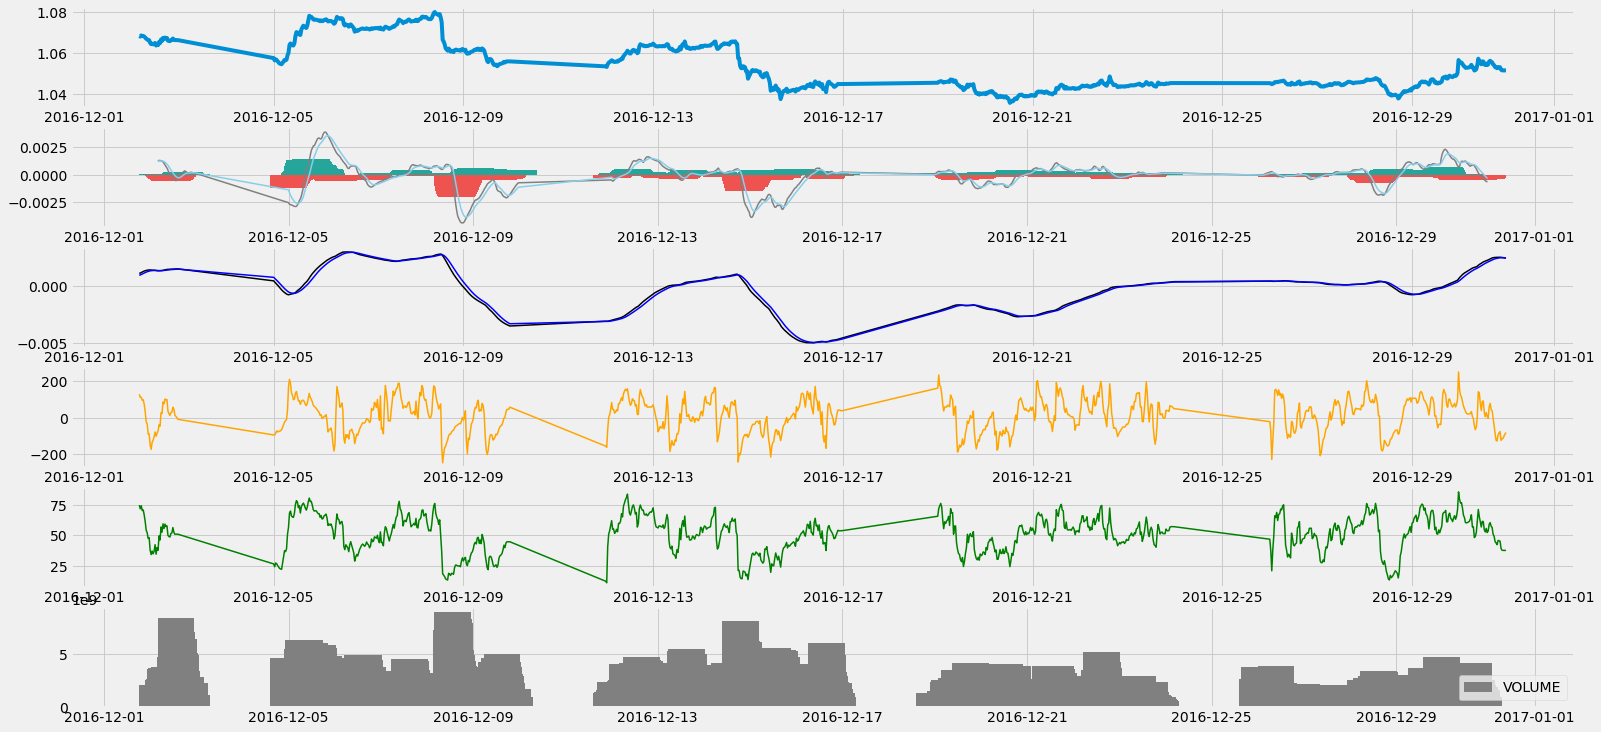

In [65]:
# Plot MACD
def plot_macd(prices, df):
    ax_price = plt.subplot2grid((6,1), (0,0),  colspan = 1)
    ax_macd = plt.subplot2grid((6,1), (1,0), colspan = 1)
    ax_macd8 = plt.subplot2grid((6,1), (2,0), colspan = 1)
    ax_cci = plt.subplot2grid((6,1), (3,0), colspan = 1)
    ax_rsi = plt.subplot2grid((6,1), (4,0), colspan = 1)
    ax_volume = plt.subplot2grid((6,1), (5,0), colspan = 1)
    # plot the prices
    ax_price.plot(prices)
    # plot the indicators
    ax_macd.plot(df['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
    ax_macd.plot(df['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
    ax_macd8.plot(df['macd8'], color = 'black', linewidth = 1.5, label = 'MACD8')
    ax_macd8.plot(df['signal8'], color = 'blue', linewidth = 1.5, label = 'SIGNAL8')
    ax_cci.plot(df['cci'], color = 'orange', linewidth = 1.5, label = 'CCI')
    ax_rsi.plot(df['rsi'], color = 'green', linewidth = 1.5, label = 'RSI')
    ax_volume.bar(prices.index, df['Volume'], color = 'grey', label = 'VOLUME')

    for i in range(len(prices)):
        if str(df['hist'][i])[0] == '-':
            ax_macd.bar(prices.index[i], df['hist'][i], color = '#ef5350')
        else:
            ax_macd.bar(prices.index[i], df['hist'][i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(sample_df['Close'], sample_df)

# Calculate max profit on each point and determine potential entry points



# Training and Validation Datasets

In [66]:
# Profit:Risk ratio : 2:1
target_rate = 0.002 # 0.2% of gain on buy and short positions
risk_rate = target_rate/2
safe_expected_margin = 2*target_rate # the profit must be 1.5*the target rate
max_duration = 8 # in periods or laggs (for example 30min* 8 = 240min = 4 hours)
# get prices
highest_prices = df['High']
lowest_prices = df['Low']
# calculte rolling min and max prices (after the possible entrypoints)
# the goal is ONLY to filter entrypoints before building the model
df['max'] = highest_prices.rolling(max_duration).max().shift(-max_duration)
# max change rate upwards
df['max_price'] = (((highest_prices.rolling(max_duration).max().shift(-max_duration)) - df['Close']) / df['Close'])
# drop the last (max_duration) rows
df = df[:-max_duration]
# generate signals for the training dataset
df['tsignal'] = df.apply(lambda row: 1 if row['max_price'] >= safe_expected_margin else 0, axis =1)
df.drop(['Open', 'High', 'Low'], axis=1)
# drop nans after replacing infinity
df['Volume'].replace(0, np.nan, inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [8]:
# get the min required volume
min_volume = df.loc[df['tsignal'] == 1].Volume.min()

# Transform dates to features

In [71]:
import datetime
from dateutil import parser
df['Time'] = pd.to_datetime(df['Time'])
df['moment'] = df['Time'].dt.dayofweek * 10000  + df['Time'].dt.hour * 60 + df['Time'].dt.minute
df.loc[df['moment'] == 40570]

,Time,Open,High,Low,Close,Volume,macd,signal,hist,macd8,signal8,hist8,cci,rsi,max,max_price,tsignal,moment
Time,,,,,,,,,,,,,,,,,,
2010-01-01 09:30:00,2010-01-01 09:30:00,1.432900,1.433335,1.432335,1.432895,1.276500e+09,0.000052,0.000035,0.000017,0.000006,8.173090e-07,0.000005,27.291468,50.163801,1.433500,0.000422,0,40570
2010-01-08 09:30:00,2010-01-08 09:30:00,1.432600,1.432925,1.431750,1.432265,1.054800e+09,0.000024,-0.000256,0.000280,-0.001136,-1.066821e-03,-0.000070,93.281647,53.076318,1.439255,0.004880,1,40570
2010-01-15 09:30:00,2010-01-15 09:30:00,1.441205,1.442080,1.440705,1.441215,1.079600e+09,-0.001979,-0.001983,0.000004,0.000067,3.956111e-04,-0.000329,-41.625711,34.412648,1.440830,-0.000267,0,40570
2010-01-22 09:30:00,2010-01-22 09:30:00,1.414720,1.416210,1.414010,1.415655,1.387550e+09,0.001308,0.001124,0.000184,-0.006768,-7.075473e-03,0.000307,123.658382,68.282263,1.415965,0.000219,0,40570
2010-01-29 09:30:00,2010-01-29 09:30:00,1.397050,1.397370,1.396200,1.396700,1.007650e+09,0.000013,-0.000550,0.000563,-0.004646,-4.651213e-03,0.000005,100.790198,55.564288,1.397555,0.000612,0,40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-02 09:30:00,2016-12-02 09:30:00,1.065775,1.065850,1.064870,1.064960,3.501870e+09,0.000343,0.000810,-0.000467,0.001399,1.317531e-03,0.000082,-150.644173,37.856876,1.065940,0.000920,0,40570
2016-12-09 09:30:00,2016-12-09 09:30:00,1.061605,1.062440,1.061350,1.062260,2.864885e+09,-0.000512,-0.000927,0.000415,-0.001517,-1.288748e-03,-0.000228,78.812625,50.781518,1.062430,0.000160,0,40570
2016-12-16 09:30:00,2016-12-16 09:30:00,1.043990,1.045555,1.043920,1.045360,3.409050e+09,0.000373,0.000162,0.000211,-0.004981,-4.967430e-03,-0.000014,117.635233,60.904396,1.046805,0.001382,0,40570


#Implement Decision Tree Model

In [72]:
# using scikitlearn to split the dataset into 80% training and 20% validation datasets 
feature_names = list(df.columns)
non_features = ['Time', 'tsignal', 'Close', 'max', 'max_price', 'Open', 'High', 'Low']
for nf in non_features:
  feature_names.remove(nf)

print(feature_names)

['Volume', 'macd', 'signal', 'hist', 'macd8', 'signal8', 'hist8', 'cci', 'rsi', 'moment']


In [73]:
# train the model
X = df[feature_names]
y = df['tsignal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70)

rfc = RandomForestClassifier(random_state=0)
rfc = rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
report = classification_report(y_test, y_pred)
print('Model accuracy', accuracy_score(y_test, y_pred, normalize=True))
print(report)

Model accuracy 0.9236488837609655
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     50256
           1       0.80      0.05      0.10      4347

    accuracy                           0.92     54603
   macro avg       0.86      0.53      0.53     54603
weighted avg       0.91      0.92      0.89     54603



In [74]:
X_train.head()

,Volume,macd,signal,hist,macd8,signal8,hist8,cci,rsi,moment
Time,,,,,,,,,,
2016-06-02 02:00:00,1.182040e+09,-0.000510,-0.000422,-0.000087,-0.000202,-0.000164,-0.000038,-134.754768,35.390755,30120
2010-11-24 21:30:00,3.157000e+08,-0.001266,-0.000993,-0.000273,-0.008217,-0.008042,-0.000175,-67.641643,40.289190,21290
2010-04-23 17:30:00,6.244000e+08,-0.001766,-0.002040,0.000274,-0.004131,-0.003932,-0.000200,-15.248630,38.691855,41050
2011-09-19 22:30:00,1.717850e+09,-0.002644,-0.001577,-0.001066,0.000374,0.000715,-0.000341,-107.292754,20.481433,1350
2013-02-01 09:30:00,3.774720e+09,0.001565,0.001262,0.000303,0.004286,0.004136,0.000150,200.121092,80.902190,40570


In [ ]:
# pull and plot the first tree
tree.plot_tree(rfc.estimators_[0],
               feature_names = feature_names, 
               class_names='tsignal',
               filled = True);

#Plot the signals

In [77]:
ddf = df.drop(non_features, axis=1)
ddf['predicted_signal'] = rfc.predict(ddf) 
ddf['Close'] = df['Close']
# reduce data
ddf = ddf[-1000:]
ddf.tail()

,Volume,macd,signal,hist,macd8,signal8,hist8,cci,rsi,moment,predicted_signal,Close
Time,,,,,,,,,,,,
2016-12-30 17:30:00,2.313985e+09,0.000596,0.000822,-0.000225,0.002488,0.002350,0.000138,-42.848621,49.328580,41050,0,1.054080
2016-12-30 18:00:00,2.535490e+09,0.000412,0.000740,-0.000328,0.002495,0.002379,0.000116,-87.052367,44.790696,41080,0,1.053105
2016-12-30 18:30:00,2.038665e+09,0.000245,0.000641,-0.000396,0.002499,0.002403,0.000096,-123.595555,43.833114,41110,0,1.052890
2016-12-30 19:00:00,1.730180e+09,0.000087,0.000530,-0.000444,0.002499,0.002422,0.000077,-127.289526,42.380824,41140,0,1.052570
2016-12-30 19:30:00,1.930745e+09,0.000007,0.000425,-0.000418,0.002505,0.002439,0.000066,-93.429945,45.852447,41170,0,1.053145


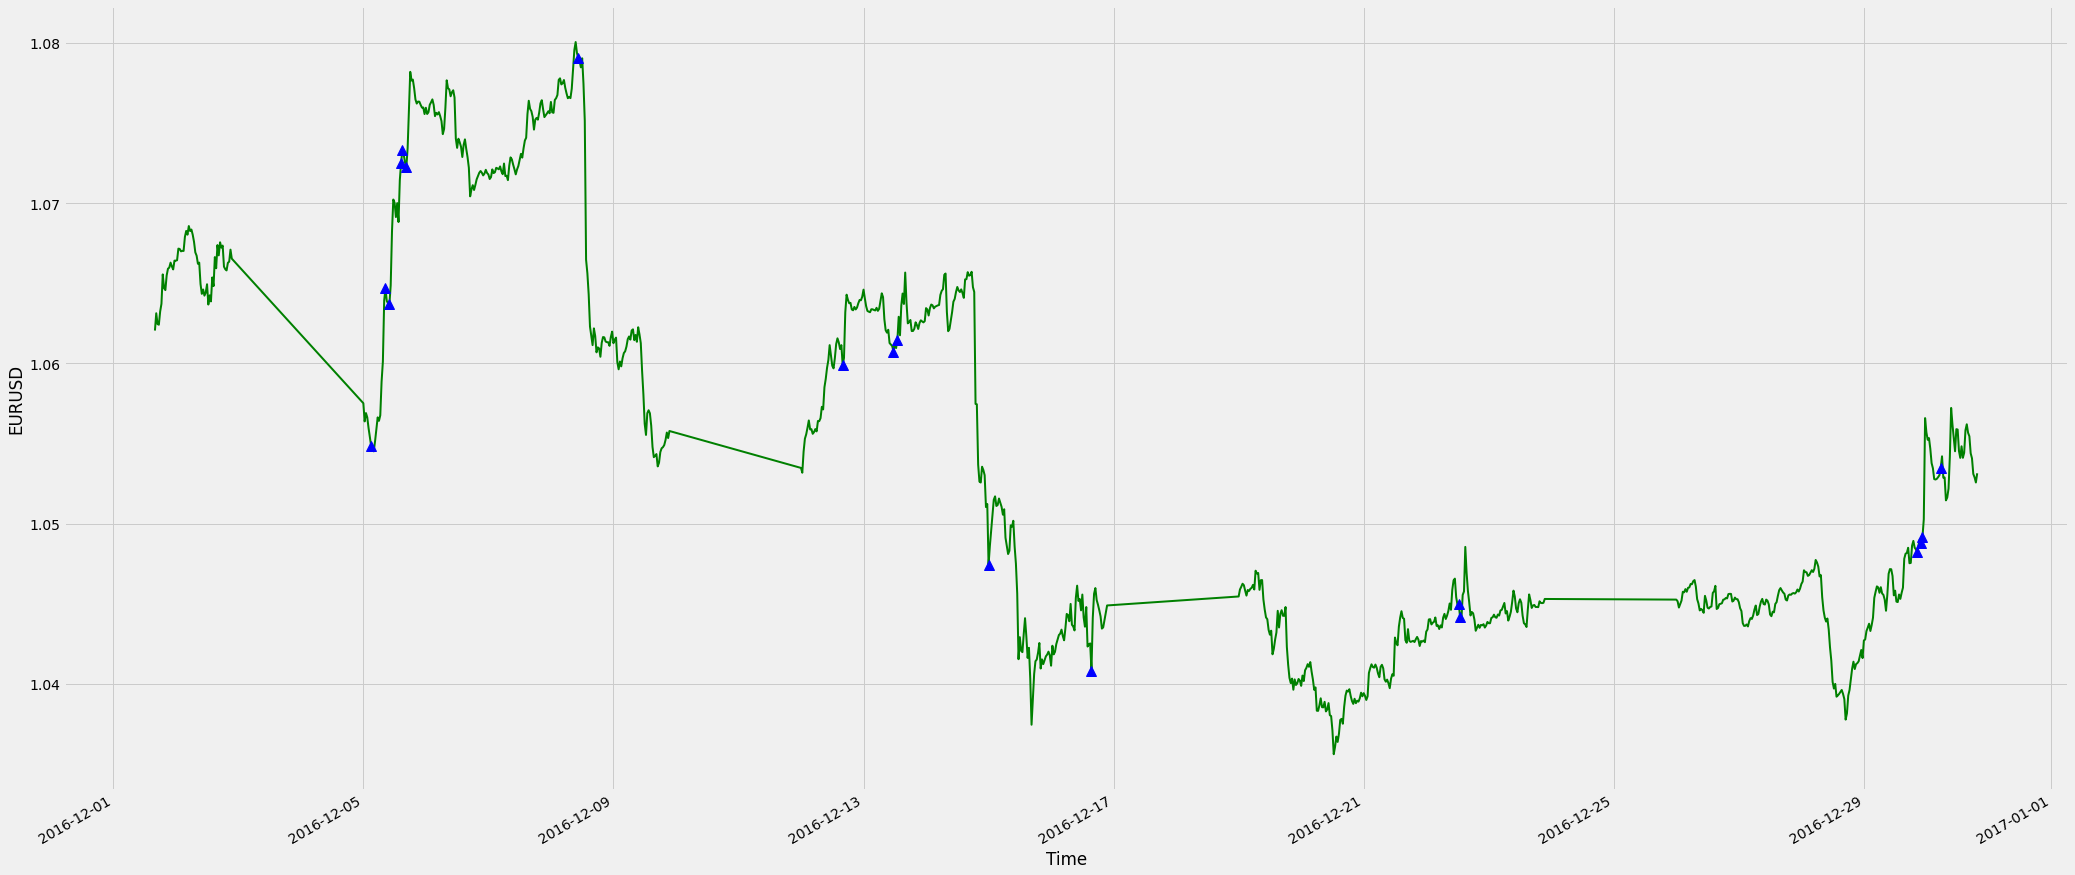

In [78]:
# Initialize the plot figure
fig = plt.figure(figsize=(32,16))

## Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,ylabel='EURUSD')

## Plot the closing price
ddf['Close'].plot(ax=ax1, color='g', lw=2.)

# Plot the buy signals
ax1.plot(ddf.loc[ddf.predicted_signal == 1.0].index, 
         ddf.Close[ddf.predicted_signal == 1.0],
         '^', markersize=10, color='b')

# Show the plot
plt.show()

# Simple Backtest

                     EURUSD  holdings   cash  total  returns
Time                                                        
2016-12-30 17:30:00     0.0       0.0  204.2  204.2      0.0
2016-12-30 18:00:00     0.0       0.0  204.2  204.2      0.0
2016-12-30 18:30:00     0.0       0.0  204.2  204.2      0.0
2016-12-30 19:00:00     0.0       0.0  204.2  204.2      0.0
2016-12-30 19:30:00     0.0       0.0  204.2  204.2      0.0


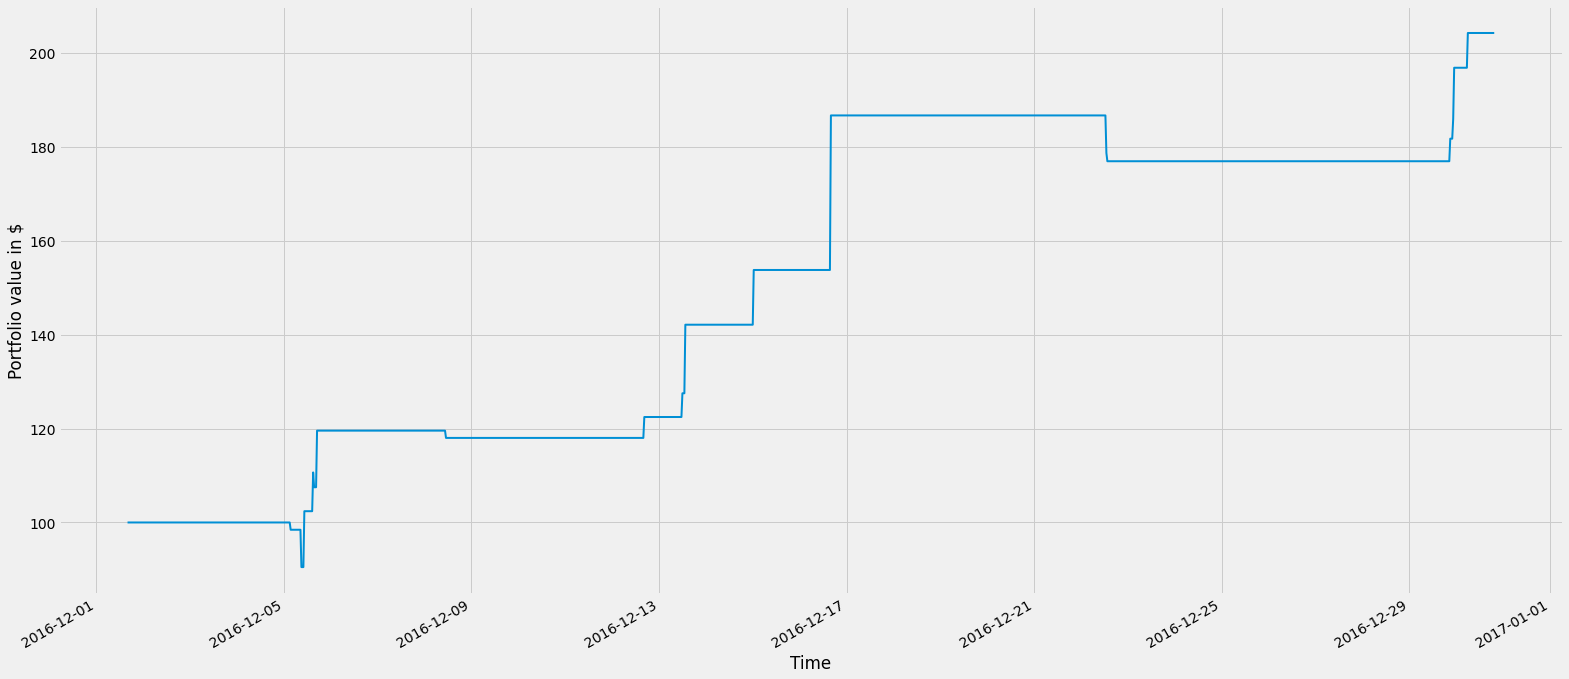

In [79]:
# Set the initial capital
initial_capital= float(100.0)
leverage = 100
# Create a DataFrame `positions`
positions = pd.DataFrame(index=ddf['predicted_signal'].index).fillna(0.0)

# Buy n share
vol = leverage * initial_capital
positions['EURUSD'] = vol*ddf['predicted_signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(ddf['Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(ddf['Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(ddf['Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = round(portfolio['cash'] + portfolio['holdings'], 2)

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio.total.plot(ax=ax1, lw=2.)


# Print the first lines of `portfolio`
print(portfolio.tail())

# Show the plot
plt.show()

#Market Scan and Test